# Visual Geometry Group (VGG16) transfer learning

Tests of the architecture with VGG16 pre-trained model.

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.legacy import Adamax
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image

In [4]:
# TRAIN_DIR = '../vgg16/data/train'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
TRAIN_DIR = os.path.abspath('../data/cinic-10_image_classification_challenge-dataset/train')
seed = 2024

In [5]:
datagen = ImageDataGenerator(validation_split=0.2)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
    seed=seed,
    target_size=(32, 32),
    batch_size=16
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    seed=seed,
    target_size=(32, 32),
    batch_size=16
)

Found 72000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


In [6]:
vgg16 = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [7]:
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
def plot_accuracy_and_loss(history_df, name, idx):
    # Plot and save accuraccy
    plt.plot(history_df['accuracy'])
    plt.plot(history_df['val_accuracy'])
    plt.title(f'{name}: accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    path = f'train_history/{name}/{idx}_accuracy.png'
    plt.savefig(path)
    print(f'Accuracy plot is saved to: {path}')
    plt.close()
    # Plot and save loss
    plt.figure()
    plt.plot(history_df['loss'])
    plt.plot(history_df['val_loss'])
    plt.title(f'{name}: loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    path = f'train_history/{name}/{idx}_loss.png'
    plt.savefig(path)
    print(f'Loss plot is saved to: {path}')
    plt.close()

def plot_confusion_matrix(name, idx):
    model = keras.models.load_model('train_history/'+name+'/'+idx+'.keras')
    X, y = zip(*(val_generator[i] for i in range(len(val_generator))))
    X_test, y_test = np.vstack(X), np.vstack(y)
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(0, 10), yticklabels=range(0, 10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix. Accuracy: {accuracy * 100:.2f}%')
    path = f'train_history/{name}/{idx}_confusion_matrix.png'
    plt.savefig(path)
    print(f'Confusion matrix is saved to: {path}')
    plt.close()
    return accuracy

def plot_accuracy_boxplot(accuracy, name): 
    plt.figure()
    plt.boxplot(accuracy)
    plt.xticks([1], [name])
    plt.title(f'{name}: Accuracy boxplot')
    path = f'train_history/{name}/boxplot.png'
    plt.savefig(path)
    print(f'Accuracy boxplot is saved to: {path}')
    plt.close()

## Test 1: VGG16 pre-trained model with extra layers

VGG16 - (Flatten) Dense (50) - Dense (20) - Dense (10)

In [12]:
name = 'vgg1'
n_epochs = 10
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

    

Attempt #1
Epoch 1/10
4500/4500 [==============================] - 699s 154ms/step - loss: 1.9860 - accuracy: 0.2869 - val_loss: 1.5103 - val_accuracy: 0.4458
Epoch 2/10
4500/4500 [==============================] - 670s 149ms/step - loss: 1.5585 - accuracy: 0.4287 - val_loss: 1.4037 - val_accuracy: 0.5019
Epoch 3/10
4500/4500 [==============================] - 674s 150ms/step - loss: 1.5005 - accuracy: 0.4544 - val_loss: 1.3872 - val_accuracy: 0.5179
Epoch 4/10
4500/4500 [==============================] - 693s 154ms/step - loss: 1.4631 - accuracy: 0.4687 - val_loss: 1.3719 - val_accuracy: 0.5264
Epoch 5/10
4500/4500 [==============================] - 704s 156ms/step - loss: 1.4365 - accuracy: 0.4806 - val_loss: 1.3956 - val_accuracy: 0.4949
Epoch 6/10
4500/4500 [==============================] - 720s 160ms/step - loss: 1.4168 - accuracy: 0.4881 - val_loss: 1.3799 - val_accuracy: 0.5250
Epoch 7/10
4500/4500 [==============================] - 702s 156ms/step - loss: 1.3976 - accuracy: 0.

## Test 2: VGG1 with dropout layers, rescaling factor and 5 epochs

VGG16 - (Flatten) Dense (50) - Dropout - Dense (20) - Dropout - Dense (10)

In [7]:
datagen = ImageDataGenerator(validation_split=0.2,
                             rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
    seed=seed,
    target_size=(32, 32),
    batch_size=16
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    seed=seed,
    target_size=(32, 32),
    batch_size=16
)

Found 72000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


In [33]:
name = 'vgg2'
n_epochs = 5
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)


Attempt #1
Epoch 1/5
4500/4500 [==============================] - 814s 180ms/step - loss: 2.0188 - accuracy: 0.2464 - val_loss: 1.6946 - val_accuracy: 0.3977
Epoch 2/5
4500/4500 [==============================] - 868s 193ms/step - loss: 1.8820 - accuracy: 0.2965 - val_loss: 1.6698 - val_accuracy: 0.3845
Epoch 3/5
4500/4500 [==============================] - 2361s 525ms/step - loss: 1.8520 - accuracy: 0.3075 - val_loss: 1.6259 - val_accuracy: 0.4082
Epoch 4/5
4500/4500 [==============================] - 916s 203ms/step - loss: 1.8382 - accuracy: 0.3150 - val_loss: 1.6114 - val_accuracy: 0.4378
Epoch 5/5
4500/4500 [==============================] - 883s 196ms/step - loss: 1.8290 - accuracy: 0.3198 - val_loss: 1.5961 - val_accuracy: 0.4416
Accuracy plot is saved to: train_history/vgg2/0_accuracy.png
Loss plot is saved to: train_history/vgg2/0_loss.png
563/563 [==============================] - 152s 269ms/step
Accuracy: 44.16%
Confusion matrix is saved to: train_history/vgg2/0_confusion_ma

## Test 3: VGG1 with normalization, rescaling factor and 5 epochs

VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [38]:
name = 'vgg3'
n_epochs = 5
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/5
4500/4500 [==============================] - 1597s 353ms/step - loss: 1.6800 - accuracy: 0.3942 - val_loss: 1.4067 - val_accuracy: 0.5072
Epoch 2/5
4500/4500 [==============================] - 1277s 284ms/step - loss: 1.5594 - accuracy: 0.4388 - val_loss: 1.3886 - val_accuracy: 0.5197
Epoch 3/5
4500/4500 [==============================] - 1063s 236ms/step - loss: 1.5235 - accuracy: 0.4521 - val_loss: 1.3849 - val_accuracy: 0.5193
Epoch 4/5
4500/4500 [==============================] - 913s 203ms/step - loss: 1.4998 - accuracy: 0.4595 - val_loss: 1.3602 - val_accuracy: 0.5307
Epoch 5/5
4500/4500 [==============================] - 789s 175ms/step - loss: 1.4819 - accuracy: 0.4680 - val_loss: 1.3746 - val_accuracy: 0.5252
Accuracy plot is saved to: train_history/vgg3/0_accuracy.png
Loss plot is saved to: train_history/vgg3/0_loss.png
563/563 [==============================] - 146s 258ms/step
Accuracy: 52.52%
Confusion matrix is saved to: train_history/vgg3/0_confusion_

## Test 4: VGG3 with dropout layers

VGG16 - (Flatten) (Batch normalization) Dense (50) - Dropout - Dense (20) - Dropout - Dense (10)

In [40]:
name = 'vgg4'
n_epochs = 5
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/5
4500/4500 [==============================] - 1146s 254ms/step - loss: 2.0543 - accuracy: 0.2439 - val_loss: 1.6866 - val_accuracy: 0.4050
Epoch 2/5
4500/4500 [==============================] - 760s 169ms/step - loss: 1.8928 - accuracy: 0.2997 - val_loss: 1.6181 - val_accuracy: 0.4471
Epoch 3/5
4500/4500 [==============================] - 777s 173ms/step - loss: 1.8533 - accuracy: 0.3201 - val_loss: 1.5870 - val_accuracy: 0.4549
Epoch 4/5
4500/4500 [==============================] - 776s 172ms/step - loss: 1.8350 - accuracy: 0.3257 - val_loss: 1.5400 - val_accuracy: 0.4646
Epoch 5/5
4500/4500 [==============================] - 764s 170ms/step - loss: 1.8183 - accuracy: 0.3362 - val_loss: 1.5474 - val_accuracy: 0.4599
Accuracy plot is saved to: train_history/vgg4/0_accuracy.png
Loss plot is saved to: train_history/vgg4/0_loss.png
563/563 [==============================] - 127s 224ms/step
Accuracy: 45.99%
Confusion matrix is saved to: train_history/vgg4/0_confusion_ma

## Test 5: VGG3 with adamax optimizer and 25 epochs (without repeating)

VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [41]:
name = 'vgg5'
n_epochs = 25
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/25
4500/4500 [==============================] - 739s 164ms/step - loss: 1.7410 - accuracy: 0.3727 - val_loss: 1.4384 - val_accuracy: 0.4913
Epoch 2/25
4500/4500 [==============================] - 739s 164ms/step - loss: 1.5852 - accuracy: 0.4304 - val_loss: 1.3916 - val_accuracy: 0.5128
Epoch 3/25
4500/4500 [==============================] - 3763s 836ms/step - loss: 1.5436 - accuracy: 0.4461 - val_loss: 1.3578 - val_accuracy: 0.5274
Epoch 4/25
4500/4500 [==============================] - 904s 201ms/step - loss: 1.5175 - accuracy: 0.4549 - val_loss: 1.3420 - val_accuracy: 0.5316
Epoch 5/25
4500/4500 [==============================] - 911s 203ms/step - loss: 1.4946 - accuracy: 0.4633 - val_loss: 1.3393 - val_accuracy: 0.5300
Epoch 6/25
4500/4500 [==============================] - 814s 181ms/step - loss: 1.4827 - accuracy: 0.4679 - val_loss: 1.3314 - val_accuracy: 0.5381
Epoch 7/25
4500/4500 [==============================] - 720s 160ms/step - loss: 1.4699 - accuracy: 0

## Test 6: VGG3 with sgd optimizer and 10 epochs (without repeating)
VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [9]:
name = 'vgg6'
n_epochs = 10
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/10
4500/4500 [==============================] - 958s 213ms/step - loss: 1.7685 - accuracy: 0.3581 - val_loss: 1.4813 - val_accuracy: 0.4701
Epoch 2/10
4500/4500 [==============================] - 798s 177ms/step - loss: 1.6019 - accuracy: 0.4217 - val_loss: 1.4176 - val_accuracy: 0.5025
Epoch 3/10
4500/4500 [==============================] - 691s 154ms/step - loss: 1.5580 - accuracy: 0.4364 - val_loss: 1.3821 - val_accuracy: 0.5101
Epoch 4/10
4500/4500 [==============================] - 688s 153ms/step - loss: 1.5343 - accuracy: 0.4459 - val_loss: 1.3590 - val_accuracy: 0.5247
Epoch 5/10
4500/4500 [==============================] - 742s 165ms/step - loss: 1.5144 - accuracy: 0.4560 - val_loss: 1.3512 - val_accuracy: 0.5262
Epoch 6/10
4500/4500 [==============================] - 725s 161ms/step - loss: 1.5005 - accuracy: 0.4594 - val_loss: 1.3367 - val_accuracy: 0.5319
Epoch 7/10
4500/4500 [==============================] - 738s 164ms/step - loss: 1.4899 - accuracy: 0.

## Test 7: VGG5 with 10 epochs (without repeating) and learning rate tuning
VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [8]:
name = 'vgg7'
n_epochs = 10
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []
rate = [0.0005, 0.001, 0.005, 0.01, 0.05]

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    print(f'Learning rate: {rate[idx]}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=rate[idx]), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Attempt #1
Learning rate: 0.0005
Epoch 1/10
4500/4500 [==============================] - 726s 161ms/step - loss: 1.8260 - accuracy: 0.3422 - val_loss: 1.5268 - val_accuracy: 0.4624
Epoch 2/10
4500/4500 [==============================] - 713s 158ms/step - loss: 1.6313 - accuracy: 0.4109 - val_loss: 1.4495 - val_accuracy: 0.4929
Epoch 3/10
4500/4500 [==============================] - 723s 161ms/step - loss: 1.5788 - accuracy: 0.4312 - val_loss: 1.3993 - val_accuracy: 0.5074
Epoch 4/10
4500/4500 [==============================] - 705s 157ms/step - loss: 1.5524 - accuracy: 0.4417 - val_loss: 1.3770 - val_accuracy: 0.5165
Epoch 5/10
4500/4500 [==============================] - 9272s 2s/step - loss: 1.5298 - accuracy: 0.4494 - val_loss: 1.3647 - val_accuracy: 0.5222
Epoch 6/10
4500/4500 [==============================] - 1183s 263ms/step - loss: 1.5148 - accuracy: 0.4554 - val_loss: 1.3506 - val_accuracy: 0.5289
Epoch 7/10
4500/4500 [==============================] - 1193s 265ms/step - loss:

## Test 8: VGG6 with learning rate tuning
VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [9]:
name = 'vgg8'
n_epochs = 10
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []
rate = [0.0005, 0.001, 0.005, 0.01, 0.05]

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    print(f'Learning rate: {rate[idx]}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.SGD(learning_rate=rate[idx]), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Attempt #1
Learning rate: 0.0005
Epoch 1/10
4500/4500 [==============================] - 708s 157ms/step - loss: 2.2391 - accuracy: 0.1731 - val_loss: 2.1116 - val_accuracy: 0.2451
Epoch 2/10
4500/4500 [==============================] - 679s 151ms/step - loss: 2.0197 - accuracy: 0.2743 - val_loss: 1.9317 - val_accuracy: 0.3164
Epoch 3/10
4500/4500 [==============================] - 679s 151ms/step - loss: 1.9084 - accuracy: 0.3124 - val_loss: 1.8170 - val_accuracy: 0.3583
Epoch 4/10
4500/4500 [==============================] - 679s 151ms/step - loss: 1.8399 - accuracy: 0.3371 - val_loss: 1.7441 - val_accuracy: 0.3806
Epoch 5/10
4500/4500 [==============================] - 683s 152ms/step - loss: 1.7973 - accuracy: 0.3501 - val_loss: 1.6913 - val_accuracy: 0.3977
Epoch 6/10
4500/4500 [==============================] - 679s 151ms/step - loss: 1.7660 - accuracy: 0.3607 - val_loss: 1.6510 - val_accuracy: 0.4131
Epoch 7/10
4500/4500 [==============================] - 680s 151ms/step - loss:

## Test 9: VGG5 with 10 epochs (without repeating), learning rate = 0.001 and batch size tuning
VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [10]:
name = 'vgg9'
n_epochs = 10
n_repeat = 5
keras.utils.set_random_seed(seed)
accuracy = []
batch = [32, 64, 128, 256, 512]

for idx in range(n_repeat):
    datagen = ImageDataGenerator(validation_split=0.2,
                             rescale=1./255)

    train_generator = datagen.flow_from_directory(
        TRAIN_DIR, 
        subset='training',
        seed=seed,
        target_size=(32, 32),
        batch_size=batch[idx]
    )

    val_generator = datagen.flow_from_directory(
        TRAIN_DIR,
        subset='validation',
        seed=seed,
        target_size=(32, 32),
        batch_size=batch[idx]
    )
    
    print(f'Attempt #{idx + 1}')
    print(f'Batch size: {batch[idx]}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')

Found 72000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.
Attempt #1
Batch size: 32
Epoch 1/10
2250/2250 [==============================] - 640s 284ms/step - loss: 1.7479 - accuracy: 0.3700 - val_loss: 1.4639 - val_accuracy: 0.4793
Epoch 2/10
2250/2250 [==============================] - 636s 283ms/step - loss: 1.5695 - accuracy: 0.4352 - val_loss: 1.3924 - val_accuracy: 0.5113
Epoch 3/10
2250/2250 [==============================] - 634s 282ms/step - loss: 1.5220 - accuracy: 0.4536 - val_loss: 1.3618 - val_accuracy: 0.5233
Epoch 4/10
2250/2250 [==============================] - 636s 283ms/step - loss: 1.4949 - accuracy: 0.4618 - val_loss: 1.3438 - val_accuracy: 0.5318
Epoch 5/10
2250/2250 [==============================] - 637s 283ms/step - loss: 1.4728 - accuracy: 0.4706 - val_loss: 1.3308 - val_accuracy: 0.5373
Epoch 6/10
2250/2250 [==============================] - 639s 284ms/step - loss: 1.4577 - accuracy: 0.4773 - val_loss: 1.3242 - val_accuracy: 0.538

## Test 10: VGG9 with batch size = 128 and extra layers
VGG16 - (Flatten) Dense (200) - (Batch normalization) Dense (100) - (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [6]:
datagen = ImageDataGenerator(validation_split=0.2,
                             rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
    seed=seed,
    target_size=(32, 32),
    batch_size=128
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    seed=seed,
    target_size=(32, 32),
    batch_size=128
)

Found 72000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


In [25]:
name = 'vgg10'
n_epochs = 10
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(units=200, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=100, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/10
563/563 [==============================] - 745s 1s/step - loss: 1.7371 - accuracy: 0.3645 - val_loss: 1.4695 - val_accuracy: 0.4854
Epoch 2/10
563/563 [==============================] - 727s 1s/step - loss: 1.5381 - accuracy: 0.4427 - val_loss: 1.4015 - val_accuracy: 0.5016
Epoch 3/10
563/563 [==============================] - 773s 1s/step - loss: 1.4758 - accuracy: 0.4656 - val_loss: 1.3541 - val_accuracy: 0.5207
Epoch 4/10
563/563 [==============================] - 701s 1s/step - loss: 1.4357 - accuracy: 0.4808 - val_loss: 1.3501 - val_accuracy: 0.5217
Epoch 5/10
563/563 [==============================] - 740s 1s/step - loss: 1.4061 - accuracy: 0.4940 - val_loss: 1.3404 - val_accuracy: 0.5262
Epoch 6/10
563/563 [==============================] - 715s 1s/step - loss: 1.3789 - accuracy: 0.5018 - val_loss: 1.3220 - val_accuracy: 0.5306
Epoch 7/10
563/563 [==============================] - 599s 1s/step - loss: 1.3568 - accuracy: 0.5117 - val_loss: 1.3130 - val_accur

## Test 11: VGG9 with batch size = 128 and extra layers
VGG16 - (Flatten) Dense (50) - (Batch normalization) (Activation) Dropout - Dense (50) - (Batch normalization) Dense (20) - Dense (10)

In [8]:
name = 'vgg11'
n_epochs = 10
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(units=50, use_bias=True)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=20, activation='tanh')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/10
563/563 [==============================] - 627s 1s/step - loss: 2.0538 - accuracy: 0.2533 - val_loss: 1.7108 - val_accuracy: 0.3952
Epoch 2/10
563/563 [==============================] - 578s 1s/step - loss: 1.8235 - accuracy: 0.3361 - val_loss: 1.5743 - val_accuracy: 0.4488
Epoch 3/10
563/563 [==============================] - 628s 1s/step - loss: 1.7482 - accuracy: 0.3662 - val_loss: 1.5250 - val_accuracy: 0.4652
Epoch 4/10
563/563 [==============================] - 583s 1s/step - loss: 1.7065 - accuracy: 0.3824 - val_loss: 1.4809 - val_accuracy: 0.4841
Epoch 5/10
563/563 [==============================] - 597s 1s/step - loss: 1.6845 - accuracy: 0.3909 - val_loss: 1.4529 - val_accuracy: 0.4926
Epoch 6/10
563/563 [==============================] - 647s 1s/step - loss: 1.6620 - accuracy: 0.3995 - val_loss: 1.4408 - val_accuracy: 0.4939
Epoch 7/10
563/563 [==============================] - 678s 1s/step - loss: 1.6466 - accuracy: 0.4056 - val_loss: 1.4231 - val_accur

## Test 14: VGG9 with batch size = 64 and data augmentation
VGG16 - (Flatten) (Batch normalization) Dense (50) - Dense (20) - Dense (10)

In [9]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        return self.n // self.batch_size

    def __next__(self):
        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

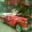

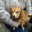

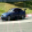

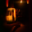

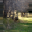

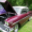

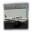

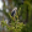

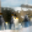

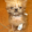

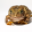

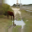

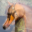

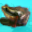

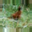

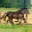

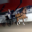

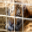

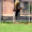

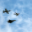

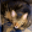

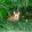

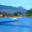

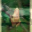

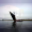

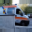

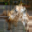

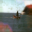

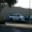

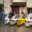

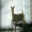

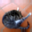

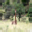

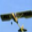

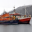

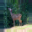

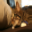

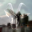

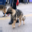

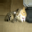

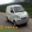

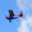

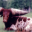

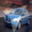

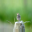

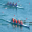

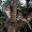

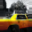

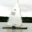

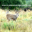

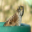

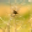

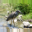

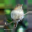

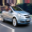

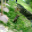

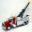

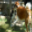

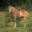

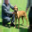

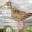

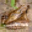

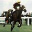

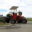

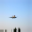

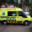

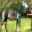

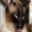

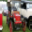

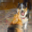

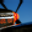

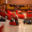

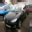

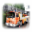

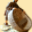

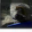

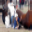

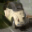

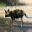

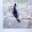

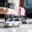

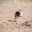

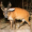

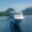

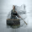

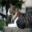

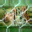

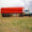

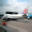

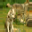

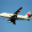

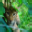

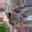

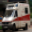

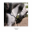

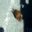

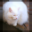

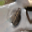

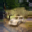

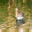

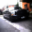

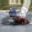

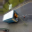

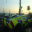

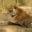

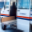

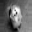

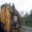

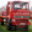

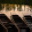

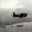

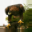

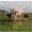

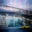

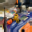

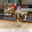

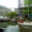

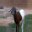

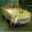

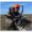

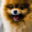

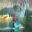

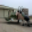

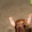

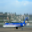

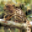

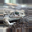

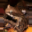

[[0.00000000e+00 6.85670816e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.80262255e-11]
 [0.00000000e+00 8.36171238e-01 0.00000000e+00 ... 1.63828762e-01
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.19436323e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [22]:
for item in train_generator:
    sample_x, sample_y = item
    for i in range(batch_size):
        display(image.array_to_img(sample_x[i]))
    print(sample_y)
    break

In [18]:
pip install --upgrade pip

   ---------------------------------------- 2.1/2.1 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
Note: you may need to restart the kernel to use updated packages.


In [19]:
! pip install mixup_generator

ERROR: Could not find a version that satisfies the requirement mixup_generator (from versions: none)
ERROR: No matching distribution found for mixup_generator


In [1]:
from mixup_generator import MixupGenerator

ModuleNotFoundError: No module named 'mixup_generator'

In [22]:
name = 'vgg12'
n_epochs = 10
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.get_steps_per_epoch(),
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/10
4500/4500 [==============================] - 936s 207ms/step - loss: 1.9132 - accuracy: 0.3283 - val_loss: 1.5666 - val_accuracy: 0.4492
Epoch 2/10
4500/4500 [==============================] - 810s 180ms/step - loss: 1.7982 - accuracy: 0.3768 - val_loss: 1.5129 - val_accuracy: 0.4756
Epoch 3/10
4500/4500 [==============================] - 784s 174ms/step - loss: 1.7703 - accuracy: 0.3911 - val_loss: 1.4645 - val_accuracy: 0.4950
Epoch 4/10
4500/4500 [==============================] - 729s 162ms/step - loss: 1.7561 - accuracy: 0.3999 - val_loss: 1.4510 - val_accuracy: 0.4987
Epoch 5/10
4500/4500 [==============================] - 737s 164ms/step - loss: 1.7429 - accuracy: 0.4039 - val_loss: 1.4416 - val_accuracy: 0.5034
Epoch 6/10
4500/4500 [==============================] - 791s 176ms/step - loss: 1.7372 - accuracy: 0.4019 - val_loss: 1.4281 - val_accuracy: 0.5074
Epoch 7/10
4500/4500 [==============================] - 736s 164ms/step - loss: 1.7256 - accuracy: 0.

In [24]:
batch_size=64
img_height=32

training_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = MixupImageDataGenerator(generator=training_datagen,
                                          directory=TRAIN_DIR,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')

val_generator = training_datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    seed=seed,
    target_size=(32, 32),
    batch_size=batch_size
)

Found 72000 images belonging to 10 classes.
Found 72000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


In [25]:
name = 'vgg13'
n_epochs = 10
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.get_steps_per_epoch(),
        validation_data=val_generator,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/10
1125/1125 [==============================] - 1014s 900ms/step - loss: 1.9456 - accuracy: 0.3157 - val_loss: 1.6101 - val_accuracy: 0.4368
Epoch 2/10
1125/1125 [==============================] - 845s 751ms/step - loss: 1.7916 - accuracy: 0.3820 - val_loss: 1.5202 - val_accuracy: 0.4696
Epoch 3/10
1125/1125 [==============================] - 797s 709ms/step - loss: 1.7503 - accuracy: 0.3993 - val_loss: 1.4771 - val_accuracy: 0.4870
Epoch 4/10
1125/1125 [==============================] - 895s 796ms/step - loss: 1.7306 - accuracy: 0.4095 - val_loss: 1.4509 - val_accuracy: 0.4969
Epoch 5/10
1125/1125 [==============================] - 756s 672ms/step - loss: 1.7145 - accuracy: 0.4159 - val_loss: 1.4367 - val_accuracy: 0.5004
Epoch 6/10
1125/1125 [==============================] - 895s 796ms/step - loss: 1.7026 - accuracy: 0.4207 - val_loss: 1.4223 - val_accuracy: 0.5109
Epoch 7/10
1125/1125 [==============================] - 715s 635ms/step - loss: 1.7009 - accuracy: 0

In [10]:
batch_size=64
img_height=32

training_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = MixupImageDataGenerator(generator=training_datagen,
                                          directory=TRAIN_DIR,
                                          batch_size=batch_size,
                                          img_height=img_height,
                                          img_width=img_height,
                                          subset='training')

val_generator = training_datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    seed=seed,
    target_size=(32, 32),
    batch_size=batch_size
)

Found 72000 images belonging to 10 classes.
Found 72000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


In [32]:
name = 'vgg14'
n_epochs = 10
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.get_steps_per_epoch()*5,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/10
5625/5625 [==============================] - 3208s 570ms/step - loss: 1.7910 - accuracy: 0.3823 - val_loss: 1.4381 - val_accuracy: 0.4983
Epoch 2/10
5625/5625 [==============================] - 2988s 531ms/step - loss: 1.6931 - accuracy: 0.4250 - val_loss: 1.4013 - val_accuracy: 0.5136
Epoch 3/10
5625/5625 [==============================] - 3451s 614ms/step - loss: 1.6690 - accuracy: 0.4352 - val_loss: 1.3829 - val_accuracy: 0.5223
Epoch 4/10
5625/5625 [==============================] - 3261s 580ms/step - loss: 1.6528 - accuracy: 0.4417 - val_loss: 1.3675 - val_accuracy: 0.5274
Epoch 5/10
5625/5625 [==============================] - 3003s 534ms/step - loss: 1.6448 - accuracy: 0.4458 - val_loss: 1.3588 - val_accuracy: 0.5322
Epoch 6/10
5625/5625 [==============================] - 3152s 560ms/step - loss: 1.6331 - accuracy: 0.4496 - val_loss: 1.3597 - val_accuracy: 0.5314
Epoch 7/10
5625/5625 [==============================] - 3230s 574ms/step - loss: 1.6276 - accur

## Test 15: VGG16 with 50 training epochs

In [11]:
name = 'vgg15'
n_epochs = 25
n_repeat = 1
keras.utils.set_random_seed(seed)
accuracy = []

for idx in range(n_repeat):
    print(f'Attempt #{idx + 1}')
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(units=50, activation='relu')(x)
    x = keras.layers.Dense(units=20, activation='relu')(x)
    x = keras.layers.Dense(units=10, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=vgg16.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adamax(learning_rate=0.001), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.get_steps_per_epoch()*5,
        epochs=n_epochs
    )
    
    model.save(f'train_history/{name}/{idx}.keras')
    history_df = pd.DataFrame(history.history) 
    hist_csv_file = 'train_history/' + name + '/' + str(idx) + '_history.csv'
    with open(hist_csv_file, mode='w') as f:
        history_df.to_csv(f)
    plot_accuracy_and_loss(history_df, name, str(idx))
    curr_accuracy = plot_confusion_matrix(name, str(idx))
    accuracy.append(curr_accuracy)
    print(f'Attempt accuracy: {curr_accuracy * 100:.2f}%')
    
accuracy_df = pd.DataFrame(data=accuracy, columns = ['accuracy'])
accuracy_csv_file = 'train_history/' + name + '/accuracy.csv'
with open(accuracy_csv_file, mode='w') as f:
    accuracy_df.to_csv(f)
print(f'Attempts accuracy is saved to {accuracy_csv_file}')
plot_accuracy_boxplot(accuracy, name)

Attempt #1
Epoch 1/2
5625/5625 [==============================] - 1159s 206ms/step - loss: 1.7907 - accuracy: 0.3824 - val_loss: 1.4403 - val_accuracy: 0.5014
Epoch 2/2
5625/5625 [==============================] - 720s 128ms/step - loss: 1.6930 - accuracy: 0.4251 - val_loss: 1.4006 - val_accuracy: 0.5121
Accuracy plot is saved to: train_history/vgg15/0_accuracy.png
Loss plot is saved to: train_history/vgg15/0_loss.png
563/563 [==============================] - 29s 51ms/step
Accuracy: 51.61%
Confusion matrix is saved to: train_history/vgg15/0_confusion_matrix.png
Attempt accuracy: 51.61%
Attempts accuracy is saved to train_history/vgg15/accuracy.csv
Accuracy boxplot is saved to: train_history/vgg15/boxplot.png
